<h1>Notebook pour usage de l'IA Générative pour obtenir le point principal d'un commentaire</h1>

In [1]:
#Librairies
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import TrainingArguments, BitsAndBytesConfig, Trainer
import torch
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
import matplotlib.pyplot as plt

c:\Users\DUNGR\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installing the Qwen2.5 0.5B Model

<h3>Convertissage du fichier excel en fichier JSONL pour du fine-tuning HuggingFace</h3>

In [2]:
# === CONFIGURATION ===
excel_file = "Commentaires topic 202325.xlsx"  # Path to your Excel file
train_file = "train.jsonl"
validation_file = "validation.jsonl"


# === READ EXCEL ===
df = pd.read_excel(excel_file, engine="openpyxl")
df.columns = ['sentence', 'theme']

In [3]:
# Check required columns
required_columns = {"sentence", "theme"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"Excel file must contain columns: {required_columns}")

# === CONVERT TO INSTRUCTION FORMAT ===
instruction_data = []
for _, row in df.iterrows():
    entry = {
        "instruction": "Summarize the sentence to get the main idea where the problem is and where it can be improved, use 1 to 5 themes MAX",
        "input": str(row["sentence"]),
        "output": str(row["theme"])
    }
    instruction_data.append(entry)

# === SPLIT INTO TRAIN AND VALIDATION ===
train_data, val_data = train_test_split(instruction_data, test_size=0.2, random_state=42)


# === SAVE TRAIN FILE ===
with open(train_file, "w", encoding="utf-8") as f:
    for item in train_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

# === SAVE VALIDATION FILE ===
with open(validation_file, "w", encoding="utf-8") as f:
    for item in val_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"✅ Train/Validation split completed: {len(train_data)} train entries, {len(val_data)} validation entries.")

✅ Train/Validation split completed: 1773 train entries, 444 validation entries.


In [9]:
# === 2. Load Base Model & Tokenizer ===
model_name = "Qwen2.5-0.5B"

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
)

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    dtype="auto",
    quantization_config=nf4_config
)

# Prepare model for LoRA fine-tuning
model = prepare_model_for_kbit_training(model)

# === 3. Prepare LoRA Config ===
lora_config = LoraConfig(
    r=4,                # Rank
    lora_alpha=8,      # Scaling
    lora_dropout=0.1,   # Dropout
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"]
)

model = get_peft_model(model, lora_config)


# Enable gradient checkpointing for memory savings
model.gradient_checkpointing_enable()


In [5]:
data_files = {
    "train": "train.jsonl",
    "validation": "validation.jsonl"
}
dataset = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
# === 4. Tokenization ===

def tokenize(batch):
    texts = [
        f"### Instruction:\n{instr}\n### Input:\n{inp}\n### Response:\n{out}"
        for instr, inp, out in zip(batch["instruction"], batch["input"], batch["output"])
    ]
    tokenized = tokenizer(texts, truncation=True, padding="max_length", max_length=128)
    tokenized["labels"] = tokenized["input_ids"].copy()  # Add labels for loss computation
    return tokenized

tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/1773 [00:00<?, ? examples/s]

Map:   0%|          | 0/444 [00:00<?, ? examples/s]

In [ ]:
instruction_data

Min: 41, Max: 123, Mean: 54.45647271087054


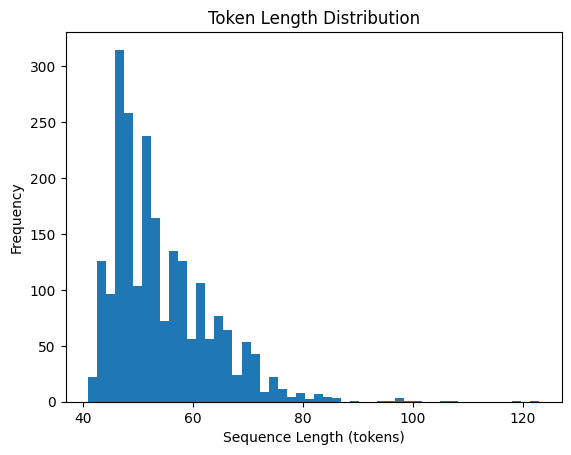

In [37]:
texts = [
    f"### Instruction:\n{item['instruction']}\n### Input:\n{item['input']}\n### Response:\n{item['output']}"
    for item in instruction_data
]

# Tokenize without truncation
tokenized = [tokenizer.encode(text, truncation=False) for text in texts]

# Compute lengths
lengths = [len(tokens) for tokens in tokenized]

# Basic stats
print(f"Min: {min(lengths)}, Max: {max(lengths)}, Mean: {sum(lengths)/len(lengths)}")

# Plot histogram
plt.hist(lengths, bins=50)
plt.xlabel("Sequence Length (tokens)")
plt.ylabel("Frequency")
plt.title("Token Length Distribution")
plt.show()


In [ ]:
# === 5. Training Arguments ===
training_args = TrainingArguments(
    output_dir="./lora-results-5",
    per_device_train_batch_size=2,  # Keep small for CPU
    per_device_eval_batch_size=2,
    learning_rate=3e-4,
    num_train_epochs=10,
    overwrite_output_dir=False,
    logging_steps=10,
    save_steps=100,
    eval_steps=100,
    disable_tqdm=False,
    logging_strategy = "steps",
    eval_strategy="steps",
    gradient_checkpointing=True,
    report_to="none",
    load_best_model_at_end= True
)


In [ ]:
# === 6. Trainer ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"]
)

# === 7. Train ===
trainer.train(resume_from_checkpoint="lora-results-5/checkpoint-8400") # "resume_from_checkpoint="lora-results-4/checkpoint-5200"

c:\Users\dungr\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
8500,0.169000,0.247157
8600,0.279600,0.246770
8700,0.179700,0.246840
8800,0.164700,0.246811


c:\Users\dungr\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\dungr\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\dungr\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=8870, training_loss=0.010577515281711651, metrics={'train_runtime': 5465.8576, 'train_samples_per_second': 3.244, 'train_steps_per_second': 1.623, 'total_flos': 4877050815774720.0, 'train_loss': 0.010577515281711651, 'epoch': 10.0})

In [ ]:
# === 8. Save Model ===
model.save_pretrained("./lora-model-qwen2.5-0.5B-fin")
tokenizer.save_pretrained("./lora-model-qwen2.5-0.5B-fin")

('./lora-model-qwen2.5-0.5B-fin\\tokenizer_config.json',
 './lora-model-qwen2.5-0.5B-fin\\special_tokens_map.json',
 './lora-model-qwen2.5-0.5B-fin\\chat_template.jinja',
 './lora-model-qwen2.5-0.5B-fin\\vocab.json',
 './lora-model-qwen2.5-0.5B-fin\\merges.txt',
 './lora-model-qwen2.5-0.5B-fin\\added_tokens.json',
 './lora-model-qwen2.5-0.5B-fin\\tokenizer.json')

In [10]:
# Base model (e.g., LLaMA, GPT-J, etc.)
base_model_name_test = "Qwen2.5-0.5B"
lora_adapter_path_test = "./lora-model-qwen2.5-0.5B-fin"

# Load tokenizer
tokenizer_test = AutoTokenizer.from_pretrained(base_model_name_test)

# Load base model
base_model_test = AutoModelForCausalLM.from_pretrained(
    base_model_name_test,
    device_map="auto",  # Automatically places layers on GPU if available
    torch_dtype="auto",
    load_in_4bit=True  # Use appropriate precision
)

base_model_test = prepare_model_for_kbit_training(base_model_test)

# Apply LoRA adapter
model_test = PeftModel.from_pretrained(base_model_test, lora_adapter_path_test)

# Merge LoRA weights if you want to export a standalone model


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [ ]:
comment = "Problem of drivers and technicians lacking behaviour"
prompt_test = f"### Instruction:\nSummarize the sentence to get the main idea where the problem is and where it can be improved\n### Input:\n{comment}\n### Response:\n"
inputs_test = tokenizer_test(prompt_test, return_tensors="pt").to(model_test.device)

outputs_test = model_test.generate(**inputs_test, max_new_tokens=128)

texter_test = tokenizer.decode(outputs_test[0], skip_special_tokens=True)
print(texter_test)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


### Instruction:
Summarize the sentence to get the main idea where the problem is and where it can be improved
### Input:
Driver training
### Response:
Technician training


In [12]:
# === 2. Load Base Model & Tokenizer ===
model_namex = "Qwen2.5-0.5B"

nf4_configx = BitsAndBytesConfig(
   load_in_4bit=True,
)

# load the tokenizer and the model
tokenizerx = AutoTokenizer.from_pretrained(model_namex)
modelx = AutoModelForCausalLM.from_pretrained(
    model_namex,
    device_map="auto",
    dtype="auto",
    quantization_config=nf4_configx
)

# Prepare model for LoRA fine-tuning
modelx = prepare_model_for_kbit_training(modelx)


In [19]:
comment = "Bad driver"
prompt_test = f"### Instruction:\nClassify the type of problem of the next sentence\n### Input:\n{comment}\n### Response:\n"
inputs_test = tokenizer_test(prompt_test, return_tensors="pt").to(model_test.device)

outputs_test = model_test.generate(**inputs_test, max_new_tokens=128)

texter_test = tokenizer_test.decode(outputs_test[0], skip_special_tokens=True)
print(texter_test)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


### Instruction:
Classify the type of problem of the next sentence
### Input:
Bad driver
### Response:
Driver training
